In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sb # pretty plots

import scipy as scp # optimization, probability densities and cumulative

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 8.0) # big figures on my computer

# Student location-scale model

We initially presented the noise model with Gaussian noise. This made the posterior partially conjugate and enabled us to perform Gibbs-Sampling on it.

However, the Gaussian model is not a very good fit to many datasets. A key problem that is has is that it doesn't correctly model the possibility of an outlier being present.

Instead, we will use in this example a Student noise model:

$$ X_i = \mu + \sigma * T_d $$

We will use the following prior:
- A Gaussian prior on $\mu$
- An exponential prior on $\sigma$ (note that since we do not plan to use conjugacy properties, it is much better to model the meaningful parameter $\sigma$ instead of the meaningless parameter $\beta$)
- A Gamma prior on $d$, ensuring that, a priori, $d\approx 4$ but with a large amount of variations. 

The posterior then has no conjugacy properties. Our only hope consists in using the very flexible Metropolis-Hastings algorithm.

### Implementing MH

In order to implement, we will do the following:

First, we will program functions which return frozen functions:
- For the various priors
- For the joint prior (combining the three preceding functions)
- For likelihood of a single datapoint
- For the joint likelihood of a dataset (combining the likelihood of every single point)
- For the posterior, combining the joint prior with the joint likelihood

For every single function, we will **work with logs** since this is more numerically stable.

Note that this division into a million functions might not be the most efficient way to do things, but it is clear and easy to debug.

Then, we will program the Metropolis-Hastings loop. It follows the loop
- Propose an update for the parameters
- Compute the MH ratio
    - This is the step where the posterior function is used
- Randomly accept or reject the update

In [3]:
def log_gaussian_prior(mu_0 = 0, sigma_0 = 5):
    ans = lambda mu: -0.5 * np.log(2 * np.pi) - np.log( sigma_0 ) - 0.5 * (mu - mu_0)**2 / sigma_0**2
    return ans

def log_gamma_prior_sigma(a_0 = 1, b_0 = 1):
    ans = lambda sigma: a_0 * np.log(b_0) - np.real(scp.special.loggamma(a_0)) + (a_0 - 1) * np.log( sigma ) - b_0 * sigma
    return ans

def log_gamma_prior_d(a_0 = 2, b_0 = 0.5):
    ans = lambda d: a_0 * np.log(b_0) - np.real(scp.special.loggamma(a_0)) + (a_0 - 1) * np.log( d ) - b_0 * d
    return ans  

In [4]:
def log_joint_prior():
    log_prior_mu    = log_gaussian_prior()
    log_prior_sigma = log_gamma_prior_sigma()
    log_prior_d     = log_gamma_prior_d()
    ans = lambda mu, sigma, d: log_prior_mu(mu) + log_prior_sigma(sigma) + log_prior_d(d)
    return ans

In [5]:
def log_student_likelihood(x):
    ans = lambda mu, sigma, d: np.real(
                                - np.log(sigma)                              # changing sigma changes the density
                                + scp.special.loggamma( (d+1)/2 )            # normal term of the student density
                                - 0.5 * np.log( d * np.pi )                  # normal term of the student density
                                - scp.special.loggamma( d/2 )                # normal term of the student density
                                - (d+1)/2 * np.log(1 + (x-mu)**2 / sigma**2 / d)   # x-dependent term of the student density
                                    )
    return ans

In [6]:
def log_posterior(data):
    log_prior = log_joint_prior()
    
    def anonymous_function(mu, sigma, d):
        ans = log_prior( mu, sigma, d )
        
        for x in data:
            log_likelihood_datapoint = log_student_likelihood(x)
            ans += log_likelihood_datapoint( mu,sigma, d ) 
            
        return ans
    
    return anonymous_function

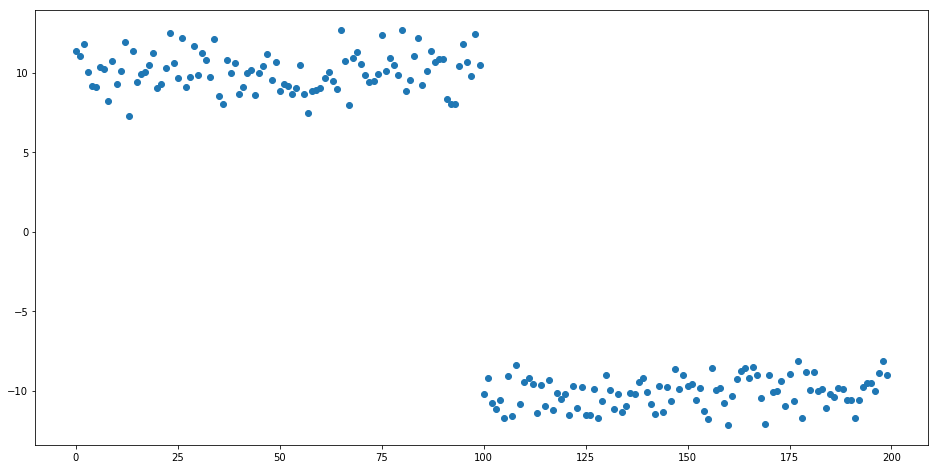

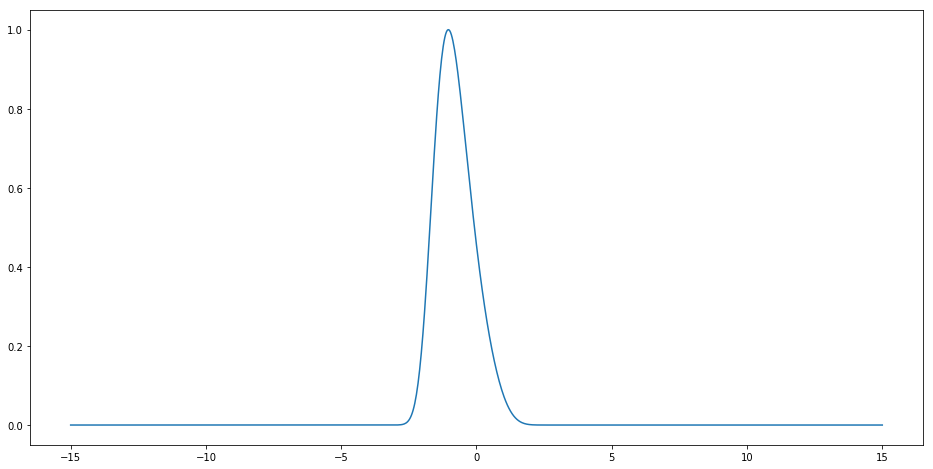

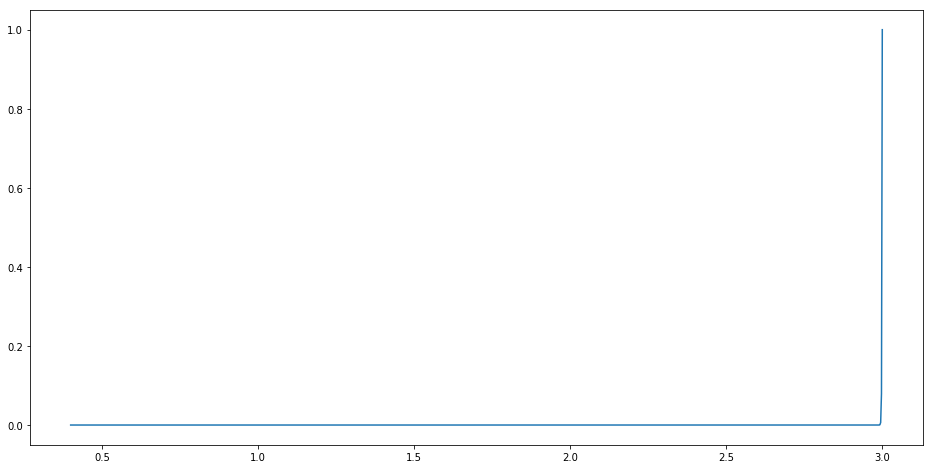

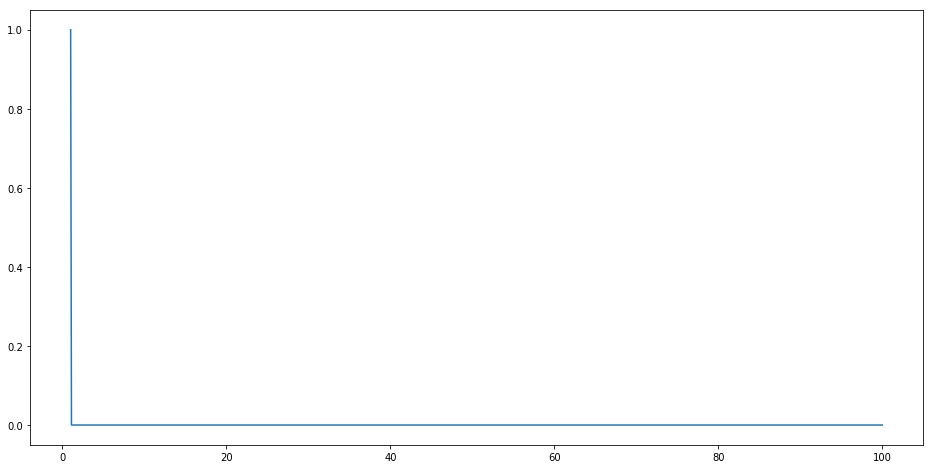

In [24]:
# a simple test of the functions
# We generate a very large dataset and check that the (conditional in this case) posterior concentrates on the correct values

# The normal exp function would return 0 for the log-values involved
def stable_exp(x_array):
    return np.exp( x_array - x_array.max() )

if True:
    #data = np.random.standard_t(4, 10000)
    
    # show the datapoints
    plt.plot( data , 'o')
    
    # show a cut of the posterior for sigma = 1, d = 4
    plt.figure()
    log_posterior_data = log_posterior(data)
    mu_array = np.linspace(-15,15, 1001)
    plt.plot( mu_array, stable_exp(log_posterior_data(mu_array, 1, 100) ) )
    
    # show a cut of the posterior for mu = 0, d = 4
    plt.figure()
    log_posterior_data = log_posterior(data)
    sig_array = np.linspace(0.4,3, 1001)
    plt.plot( sig_array, stable_exp(log_posterior_data(10, sig_array, 100) ) )
    
    # show a cut of the posterior for mu = 0, sigma = 1
    plt.figure()
    log_posterior_data = log_posterior(data)
    d_array = np.linspace(1,100, 1001)
    plt.plot( d_array, stable_exp(log_posterior_data(10, 1, d_array) ) )
    
    plt.show()

In [8]:
def metropolis_hastings(log_posterior_function, step_size = 0.05, num_samples = 10000, decimation = 1, **kwargs):
    samples = np.zeros( [num_samples, 3] )
    record_acceptance = np.zeros( [num_samples] )
    
    if "initial" in kwargs.keys():
        current = np.array( [ kwargs["initial"] ] )
    else:
        current = np.array( [0, 1, 4] ) # order is mu, sigma, d
    
    for k in range(num_samples):
        for dummy in range(decimation):
            proposal = current + step_size * np.random.randn(3)
            ratio_MH = np.exp( log_posterior_function(*proposal) - log_posterior_function(*current) )
            
            uniform_RV = np.random.random()
            if uniform_RV < ratio_MH:
                current = proposal
                
        samples[k,:] = current
        record_acceptance[k] = (uniform_RV < ratio_MH)
        
    print("Acceptance rate : ", np.mean(record_acceptance) )
    return samples

In [16]:
#MIXTURE OF GAUSSIAN
from scipy.stats import  norm
x1 = norm.rvs(loc=10., scale = 1.,size=100)
x2 = norm.rvs(loc= -10., scale = 1.,size=100)
data= np.concatenate([x1,x2])

(array([68., 32.,  0.,  0.,  0.,  0.,  0.,  2., 54., 44.]),
 array([-12.16784643,  -9.68137964,  -7.19491286,  -4.70844607,
         -2.22197929,   0.2644875 ,   2.75095428,   5.23742107,
          7.72388786,  10.21035464,  12.69682143]),
 <a list of 10 Patch objects>)

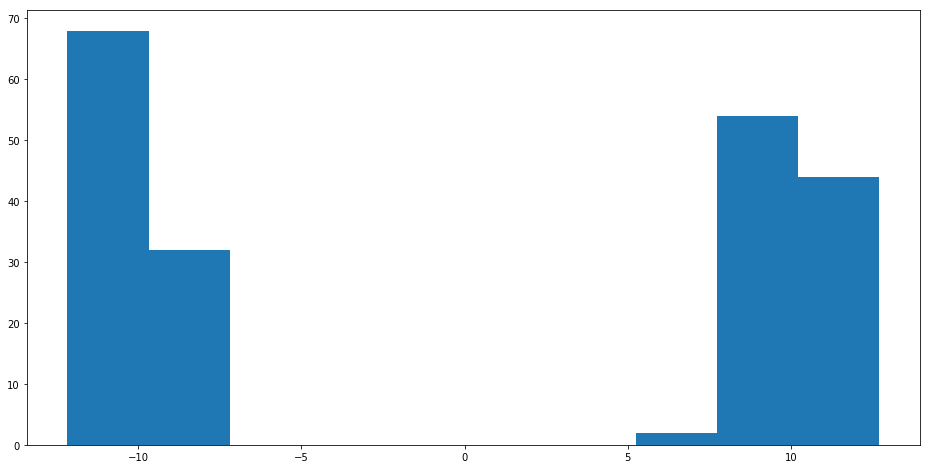

In [21]:
plt.hist(data)

In [17]:
#data = np.random.standard_t(4, 100)
log_posterior_data = log_posterior(data)
samples = metropolis_hastings( log_posterior_data )

('Acceptance rate : ', 0.0)


In [18]:
def autocorrelation(time_series, maxRange):
    # estimate the autocorrelation, correctly normalized, for all the lags in the delta array
    l = len(time_series)
    
    ans = np.zeros(2*maxRange+1)
    delta = np.arange(-maxRange,maxRange+1,1)
    
    for k in range(2*maxRange+1):
        v0 = time_series[maxRange            : l - maxRange           ]
        v1 = time_series[maxRange - delta[k] : l - maxRange - delta[k]]
        
        m0 = np.mean(v0)
        m1 = np.mean(v1)
        cov = np.sum( (v0-m0) * (v1-m1) / len(v0) )
        var0 = np.sum( (v0-m0)**2 / len(v0) )
        var1 = np.sum( (v1-m1)**2 / len(v0) )
        corr = cov / (var0 * var1)**0.5
        
        ans[k] = corr
        
    return delta, ans
    

def showAutocorrelation(samples, delta = None):
    if delta == None:
        delta = np.int( len(samples) / 6 )
    _, trueCorrelation = autocorrelation(samples, delta )
        
    #plt.plot(np.arange(-len(reduced),len(reduced)-1),correlation / correlation.max(), 'o')
    plt.plot(np.arange(-delta,delta+1), trueCorrelation, 'o')
    plt.ylim([-1,1])
    #plt.show()

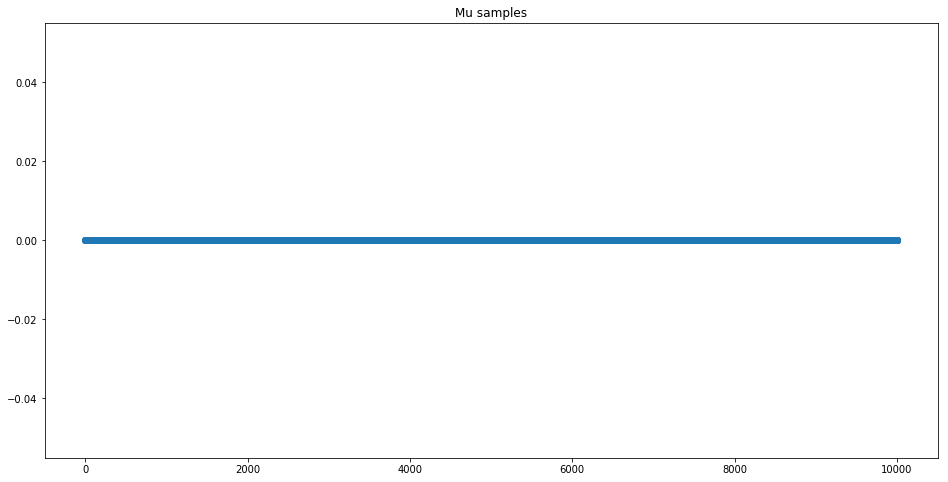

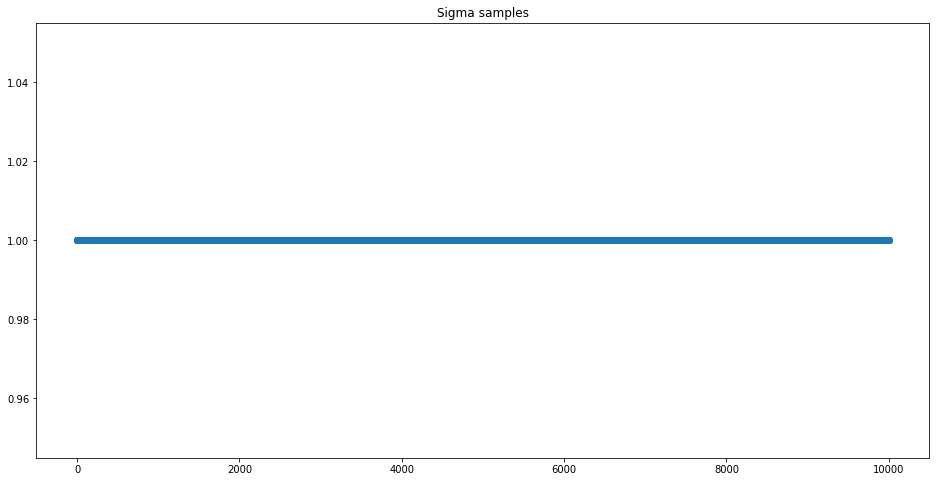

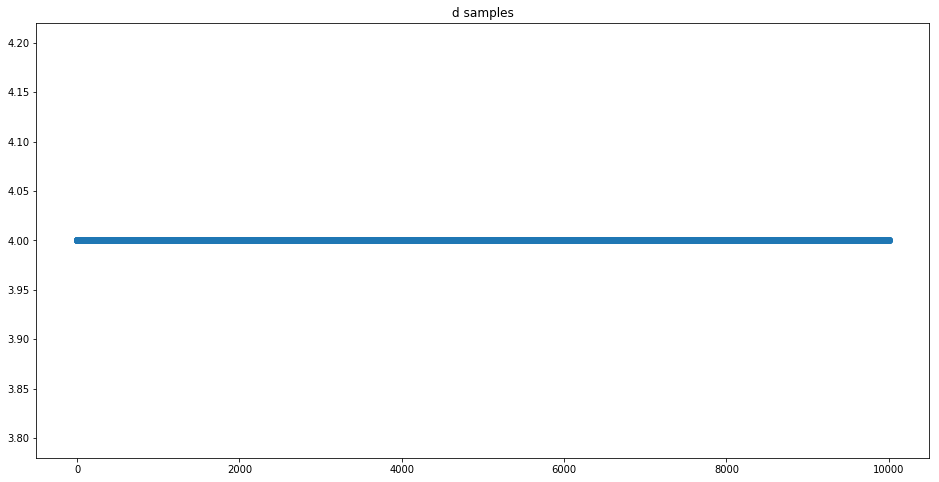

In [22]:
# Let's visualize the samples of each parameter
# Notice how the samples of d appear to be much more correlated than those of mu and sigma

plt.figure()
plt.plot(samples[:,0], 'o')
plt.title("Mu samples")

plt.figure()
plt.plot(samples[:,1], 'o')
plt.title("Sigma samples")

plt.figure()
plt.plot(samples[:,2], 'o')
plt.title("d samples")
plt.show()

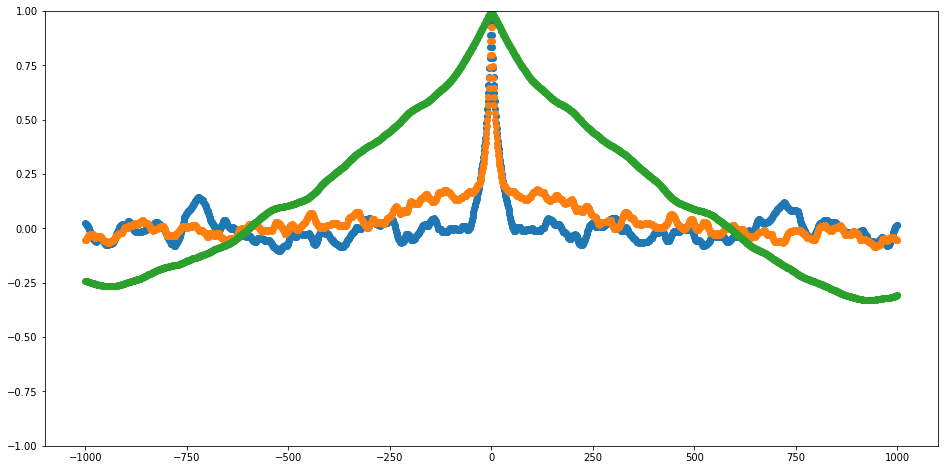

In [12]:
# Let's plot the autocorrelation of each coordinate
# It appears that the d coordinate (in red) is mixing very slowly !
# We might want to change our proposal

showAutocorrelation(samples[:,0], delta = 1000) # mu    = blue
showAutocorrelation(samples[:,1], delta = 1000) # sigma = green
showAutocorrelation(samples[:,2], delta = 1000) # d     = red
plt.show()

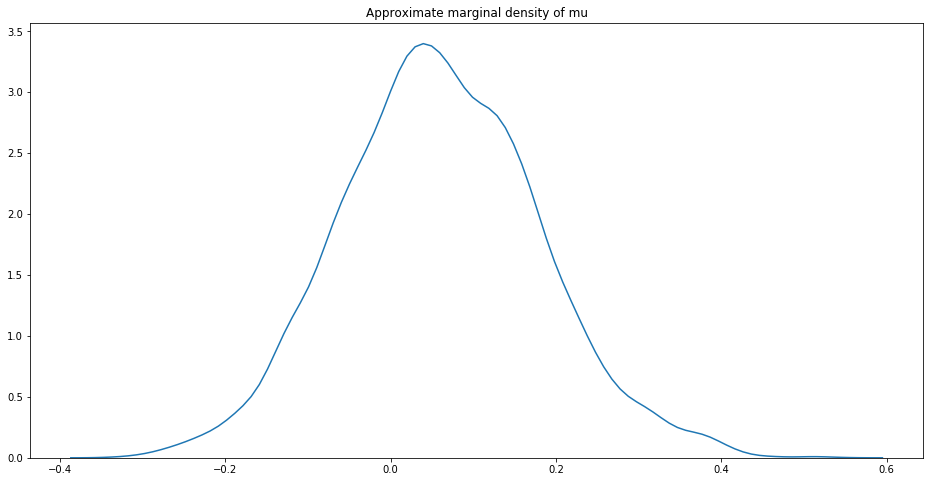

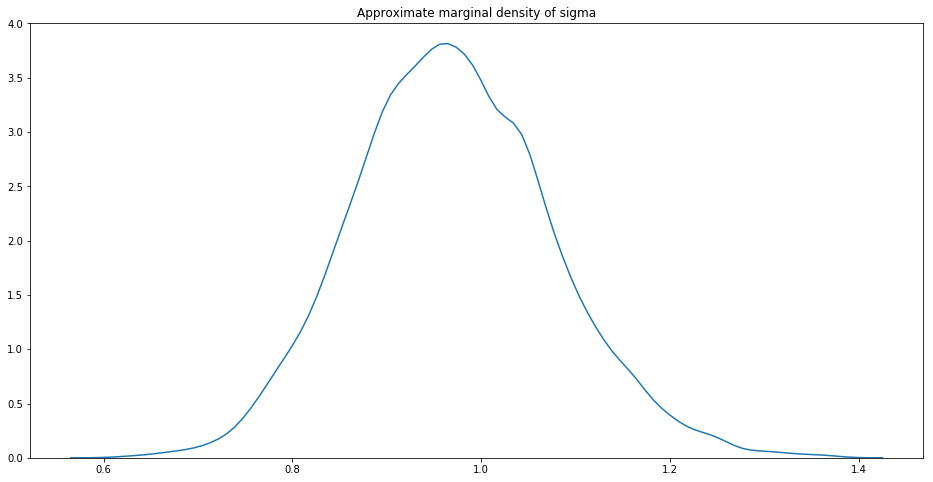

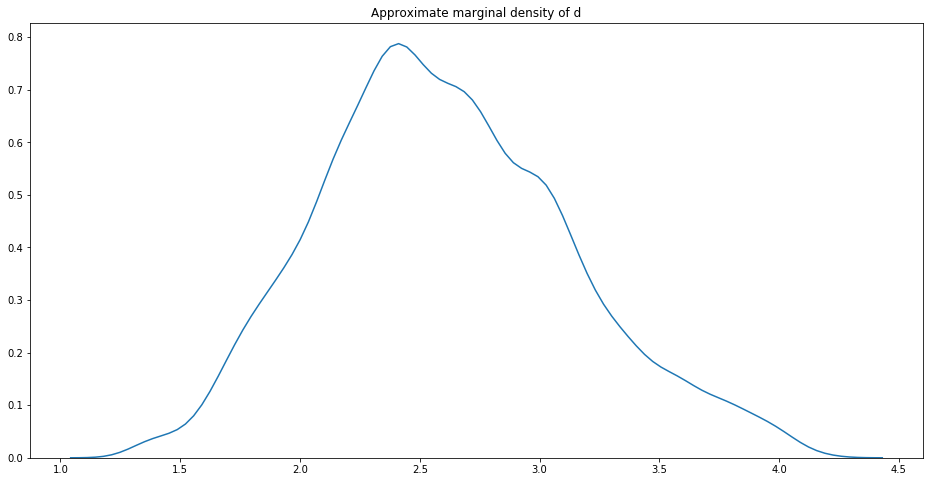

In [13]:
# We can plot the density of the samples of each variable

plt.figure()
sb.kdeplot(samples[:,0])
plt.title("Approximate marginal density of mu")

plt.figure()
sb.kdeplot(samples[:,1])
plt.title("Approximate marginal density of sigma")

plt.figure()
sb.kdeplot(samples[:,2])
plt.title("Approximate marginal density of d")

plt.show()

In [14]:
# We can finally compute the posterior mean
# Note that, because of the huge autocorrelation in d, we might not want to trust this value

posterior_mean_approximation = np.mean(samples, axis = 0)

print("Posterior mean estimator : ", posterior_mean_approximation)

('Posterior mean estimator : ', array([0.05990322, 0.97027005, 2.60856445]))


In [15]:
np.std(samples,axis=0)

array([0.12006242, 0.10568624, 0.5274135 ])